In [1]:
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import fusion
import time
import numpy as np


# Visualization of trace img in files

In [55]:
# Bad images
# Circles
bad_img_circl = [280, 292, 287, 377]
# Horizontal line
bad_img_hor = [85]
# Vertical line
bad_img_vert = []

In [53]:
def start_angle(a):
    norm = sum(a ** 2) ** 0.5
    a = a / norm
    ψ = np.arcsin(a[0])
    ϕ = np.arctan2(a[1], a[2])
    return ψ, ϕ

def visualize_file(file_name, line_threshold = 0):
    data = []
    n_line = 0
    with open(file_name,'r') as f:
        for line in f:
            result = re.findall(r"-?\d+.\d+", line)
            if len(result) == 10:
                data.append([float(x) for x in result])
                n_line += 1
            
    if n_line < line_threshold:
        return 
                
    pitch, roll = start_angle(np.array(data[0][1:4]))
    fusioner = fusion.Fusion(roll=roll, pitch=pitch)
    dtime = 0.02
    angles = []
    for a in data:
        fusioner.update_nomag(dtime, (a[1], a[2], a[3]), (a[4], a[5], a[6]))
        #fusioner.update_nomag(a[0], (a[1], a[2], a[3]), filtered_g)
        angles.append([fusioner.pitch, fusioner.heading, fusioner.roll])
    angles[0] = angles[1]
    
    data_x = [x[1] for x in angles]
    data_y = [x[0] for x in angles]
    plt.plot([x[1] for x in angles], [x[0] for x in angles])
    plt.ylim(-90, 90)
    plt.xlim(-90, 90)
    plt.show()
    
def number_of_lines(file_name):
    data = []
    n_line = 0
    with open(file_name,'r') as f:
        for line in f:
            result = re.findall(r"-?\d+.\d+", line)
            if len(result) == 10:
                n_line += 1
    return n_line

In [73]:
# N_vert = 5
# line_threshold = 15
# for i in range(N_vert):
#     print(i)
#     visualize_file("data_for_recognition/accelerometer/vertical_%d.dat"%i, line_threshold)

# Creation of numpy dataset

In [45]:
def signal_filter(data, x1, x2):
    data = data.transpose()
    res = np.zeros_like(data)
    for i, x in enumerate(data):
        b, a = signal.butter(x1, x2)
        y = signal.filtfilt(b, a, x)
        res[i] = y
    return res.transpose()

def discretize_data(data, n_points):
    step = len(data) / n_points
    data = data.transpose()
    res = np.zeros((data.shape[0], n_points))
    for i, x in enumerate(data):
        for j in range(n_points):
            res[i, j] = np.mean(data[i, int(j * step):int((j+1) * step)])
    return res.transpose()

def create_data_set(files, n_points):
    N = len(files)
    data = np.zeros((N, n_points, 6))
    for i, file in enumerate(files):
        row_data = []
        with open(file,'r') as f:
            for line in f:
                result = re.findall(r"-?\d+.\d+", line)
                if len(result) == 10:
                    row_data.append([float(x) for x in result])
        
        smooth_data = signal_filter(np.array(row_data)[:,1:7], 3, 0.2) 
        
        data[i] = discretize_data(smooth_data, n_points)
    return data

In [57]:
file_name = "data_for_recognition/accelerometer/vertical_%d.dat"
n_points = 15
files = [file_name%i for i in range(103) if i not in bad_img_vert and number_of_lines(file_name % i) > n_points]
data = create_data_set(files, n_points)

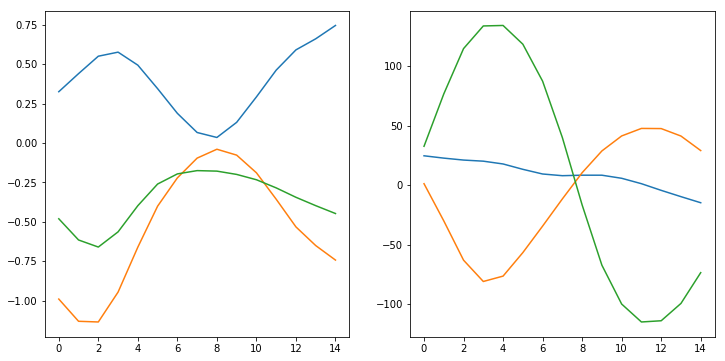

In [61]:
def visualize_data_set(data):
    for traj in data:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(traj[:, 0])
        ax[0].plot(traj[:, 1])
        ax[0].plot(traj[:, 2])
        
        ax[1].plot(traj[:, 3])
        ax[1].plot(traj[:, 4])
        ax[1].plot(traj[:, 5])
        plt.show()
        
visualize_data_set([np.mean(data, axis=0)])

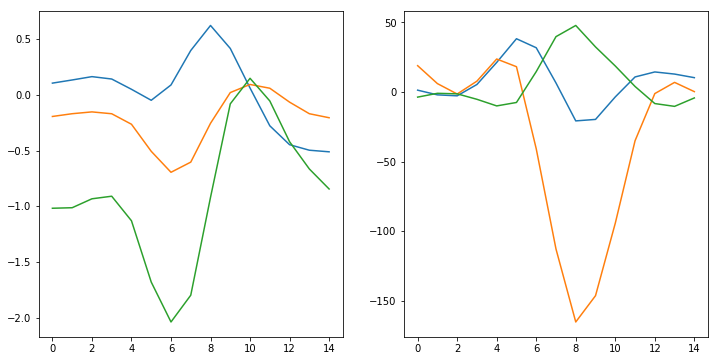

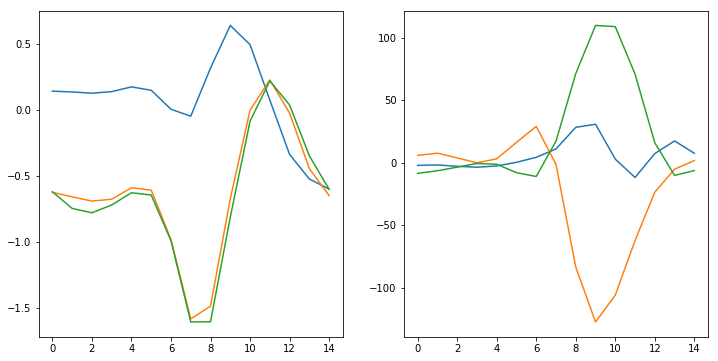

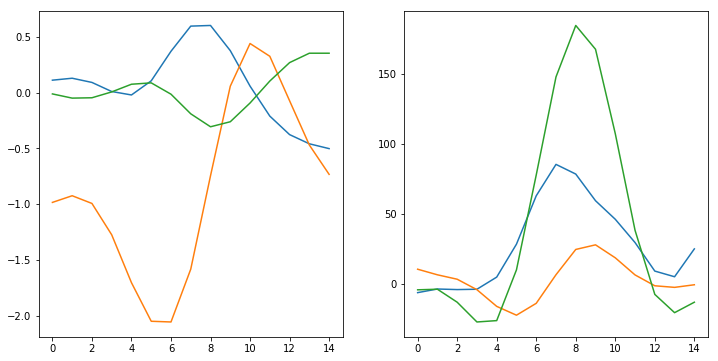

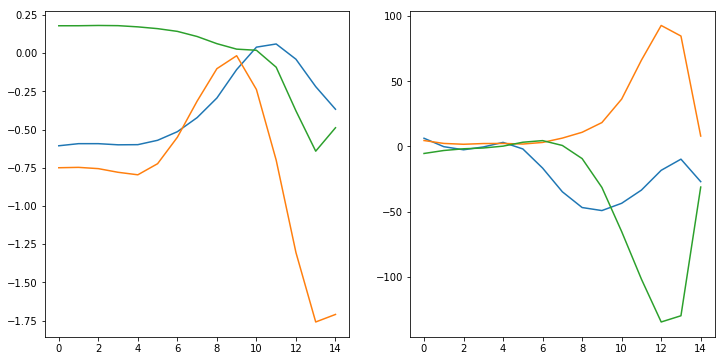

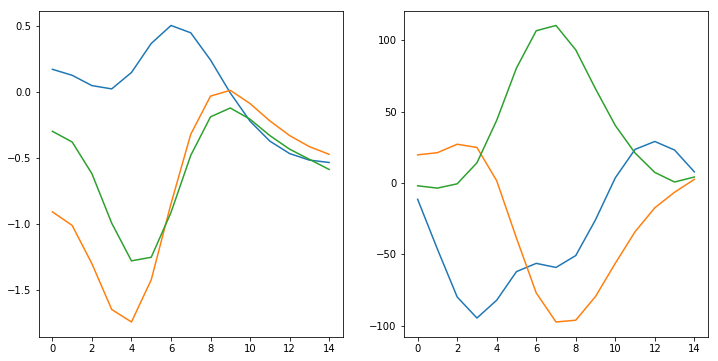

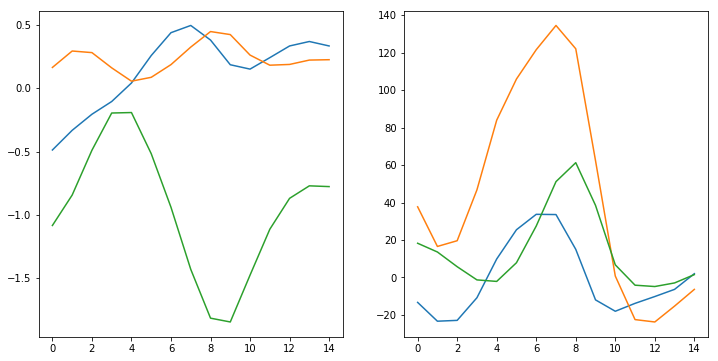

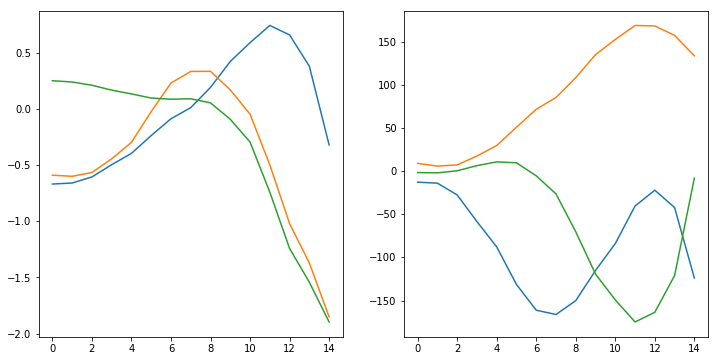

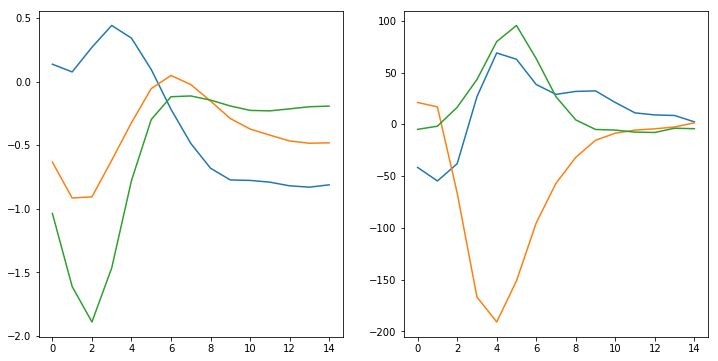

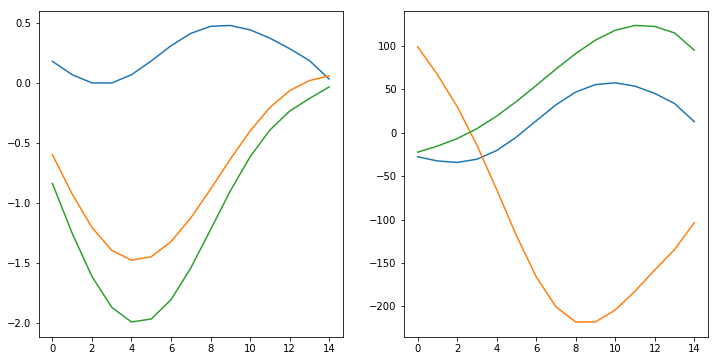

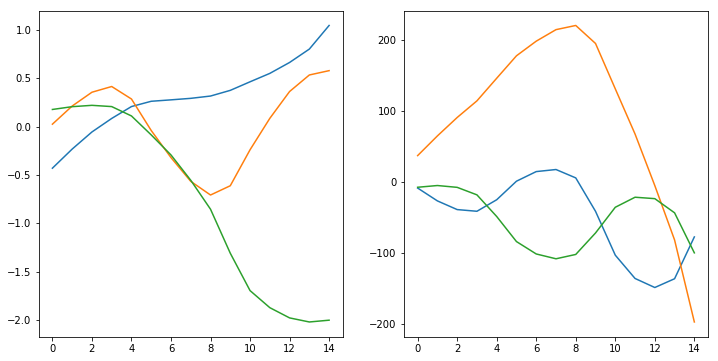

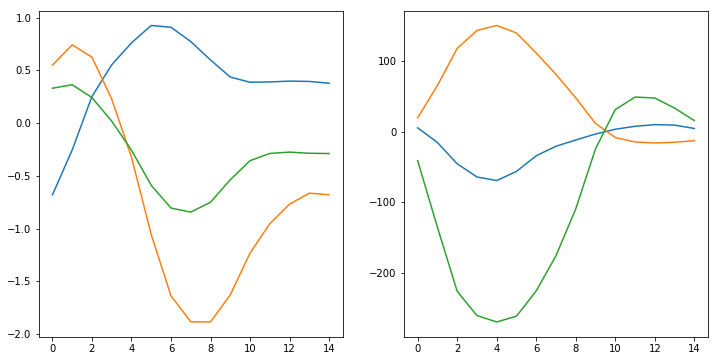

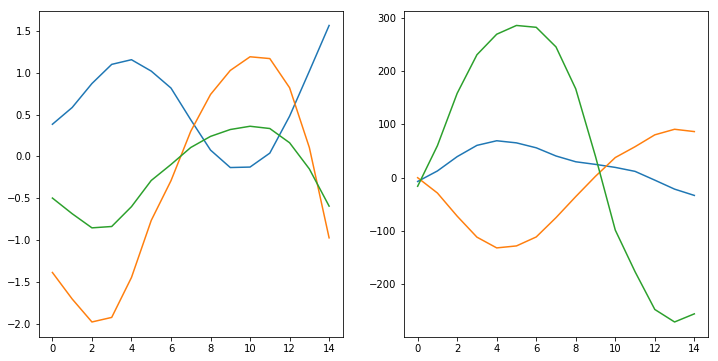

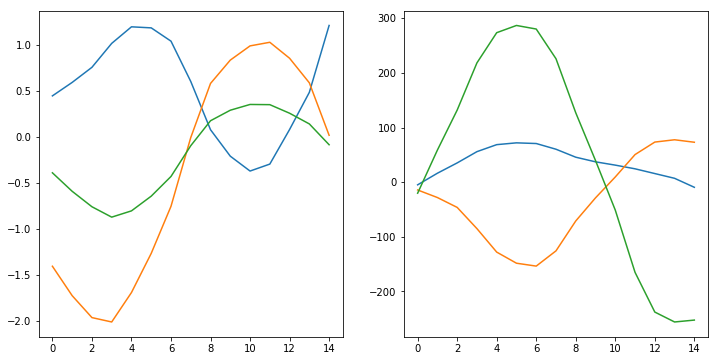

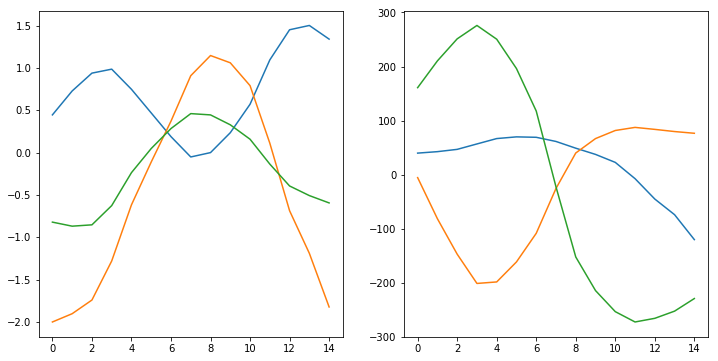

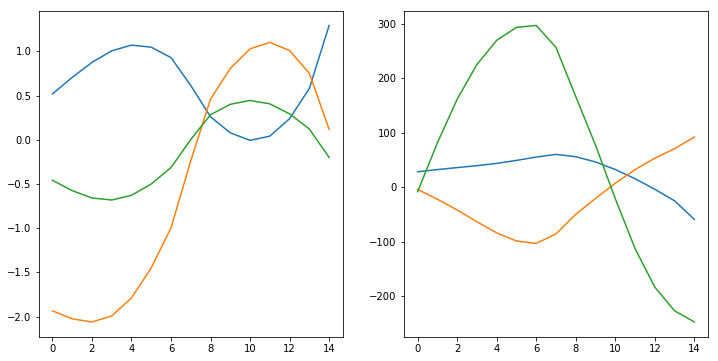

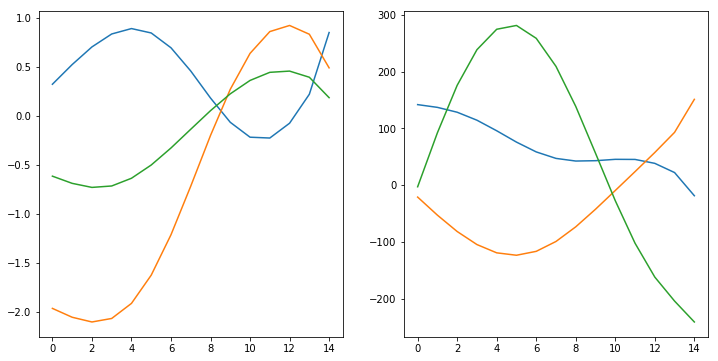

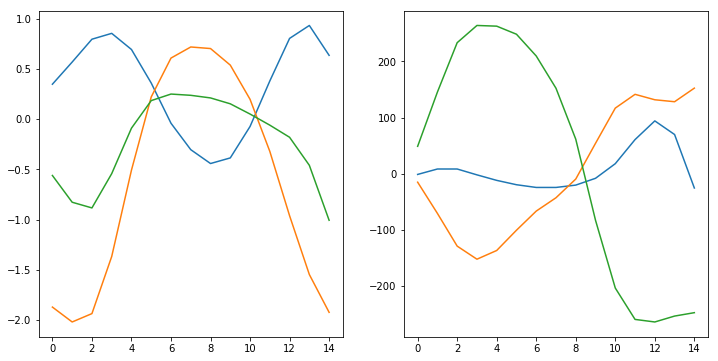

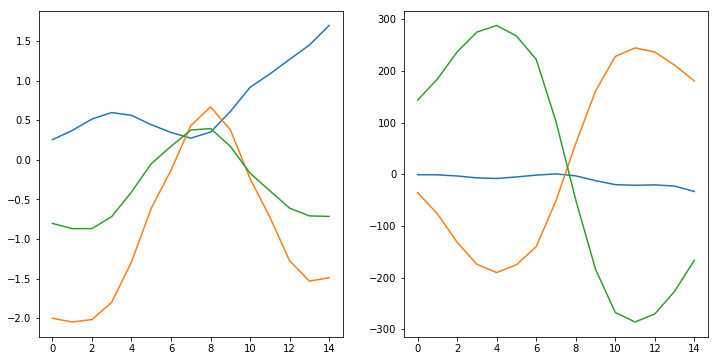

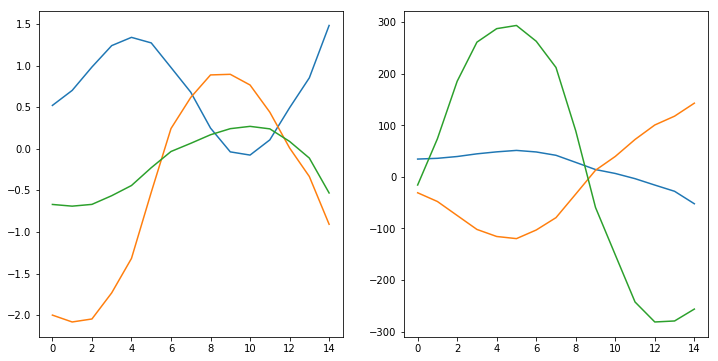

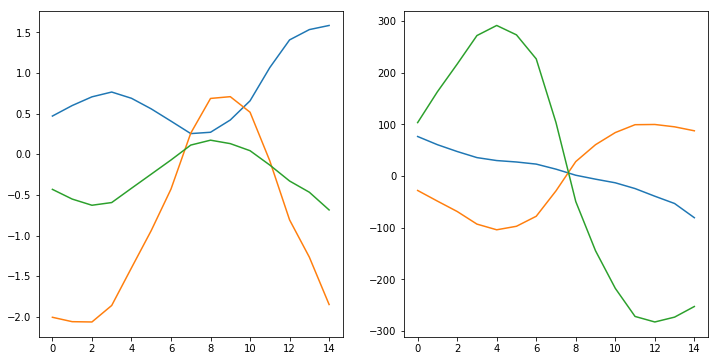

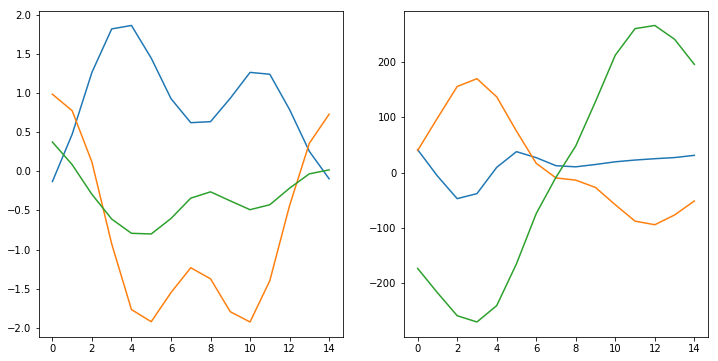

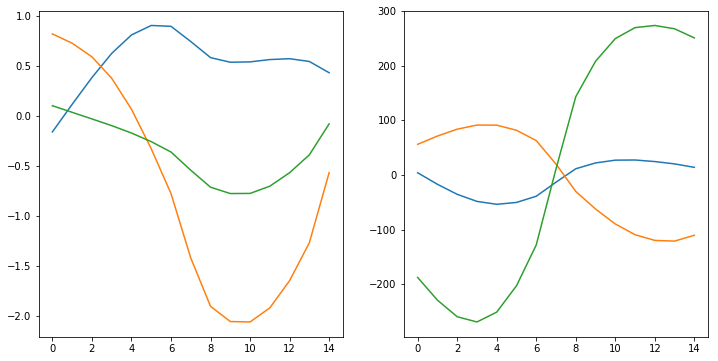

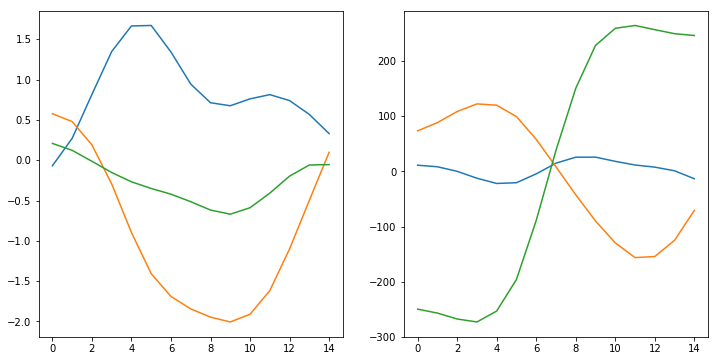

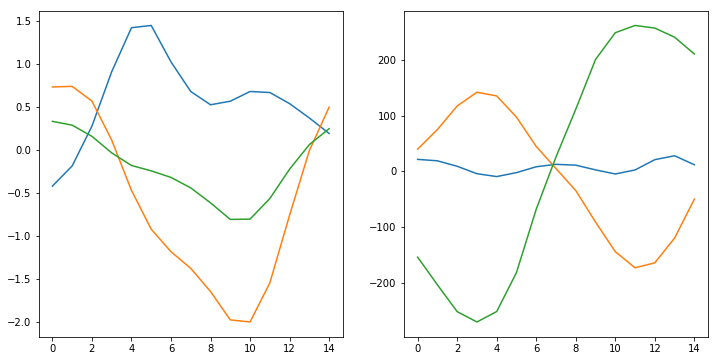

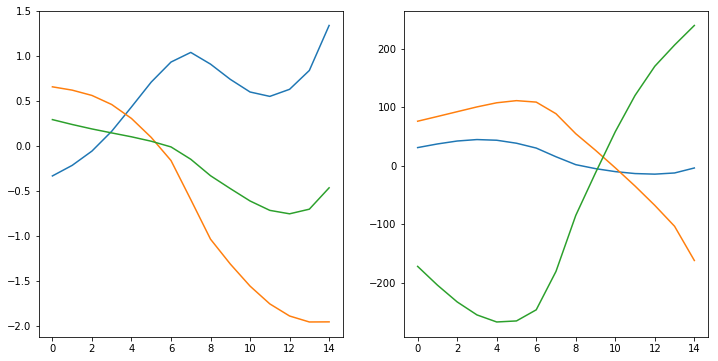

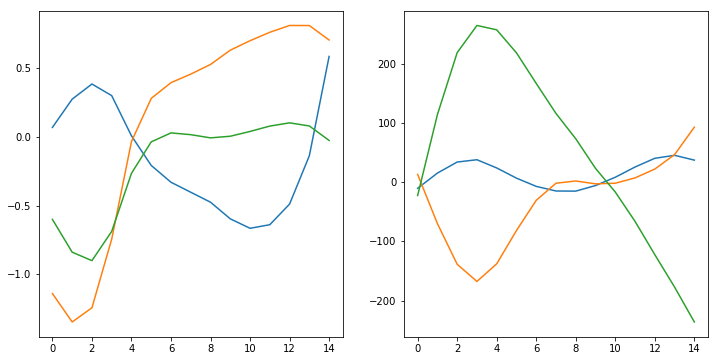

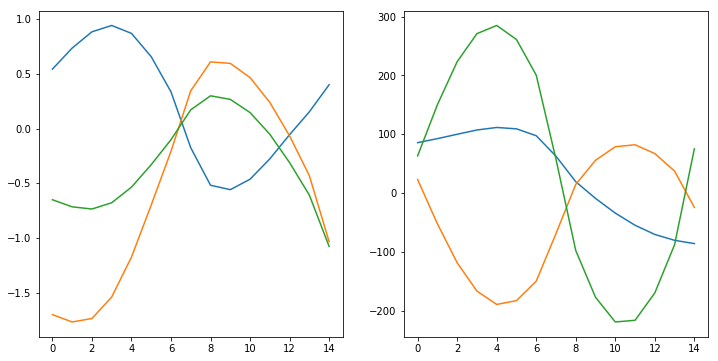

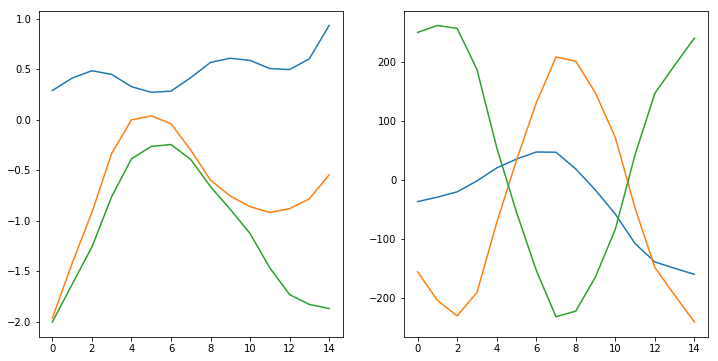

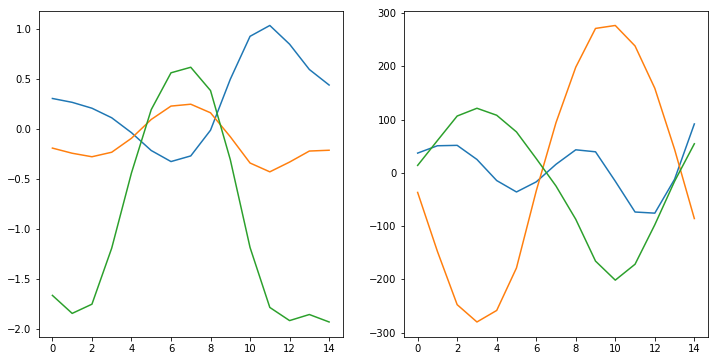

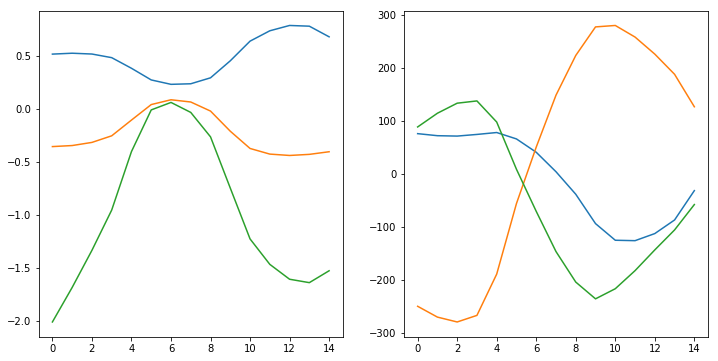

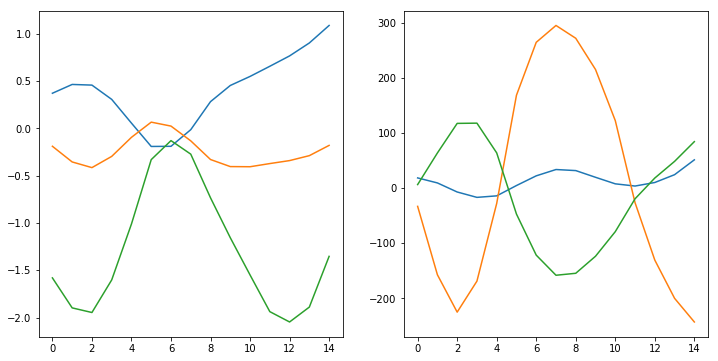

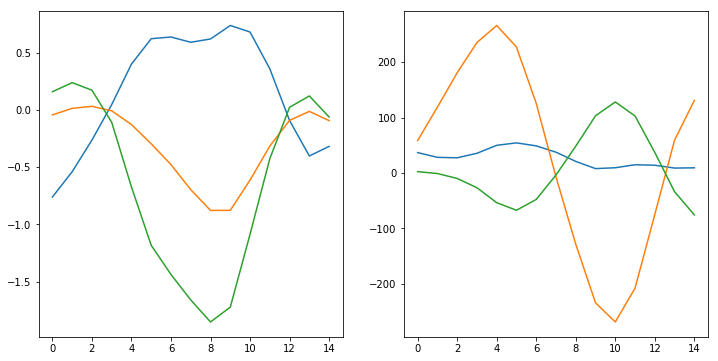

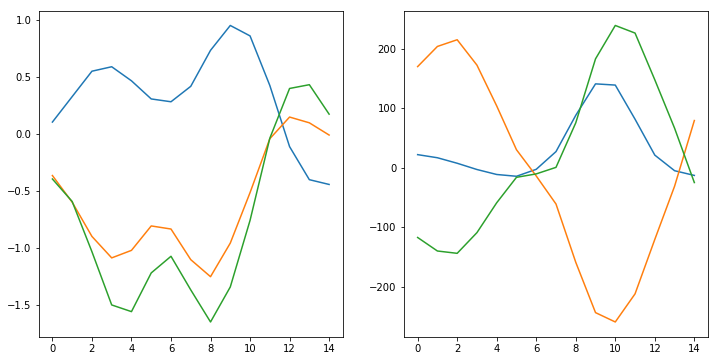

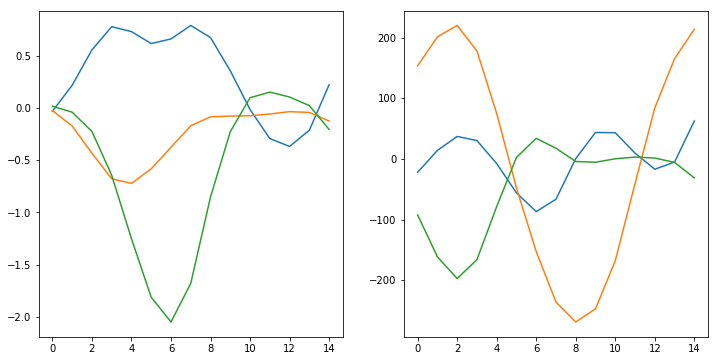

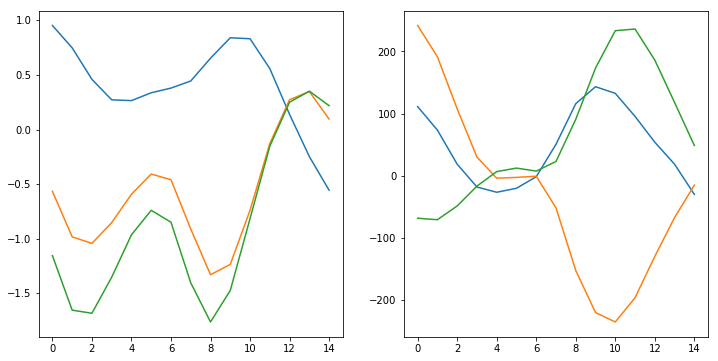

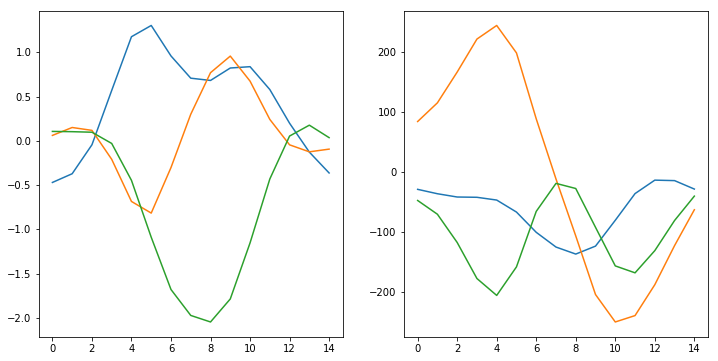

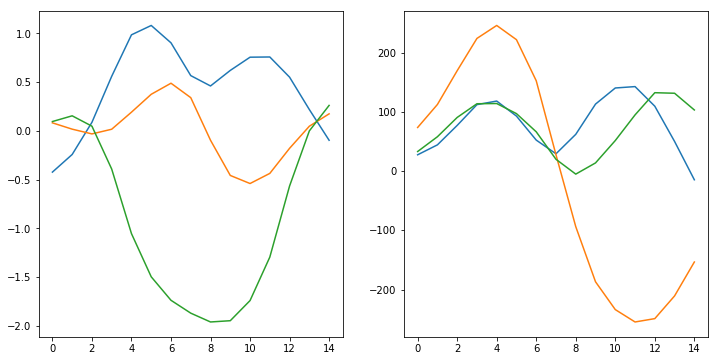

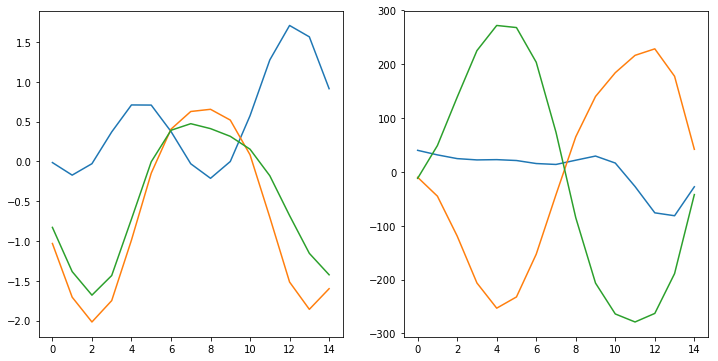

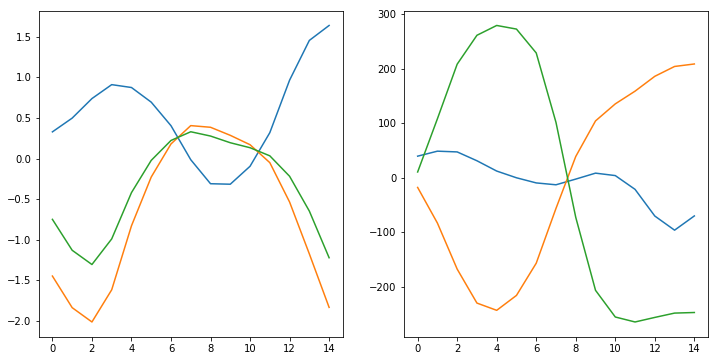

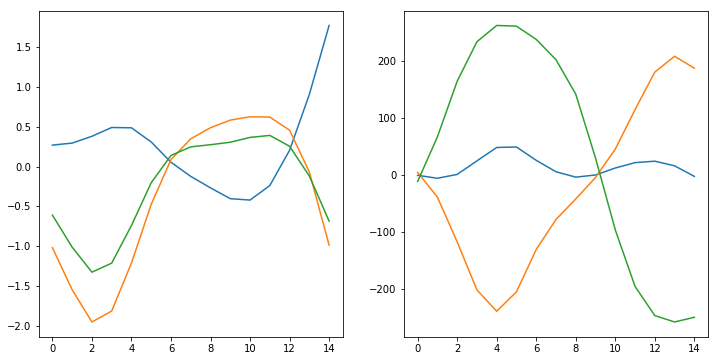

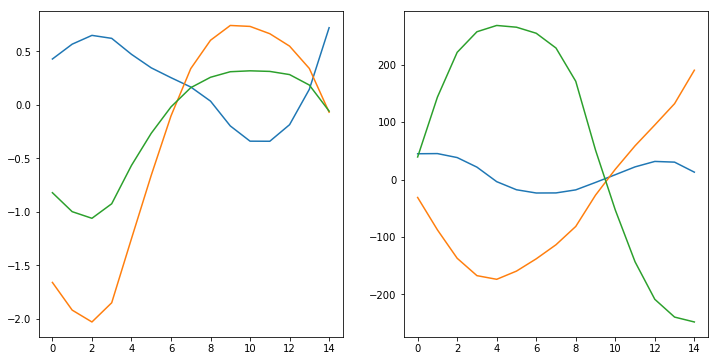

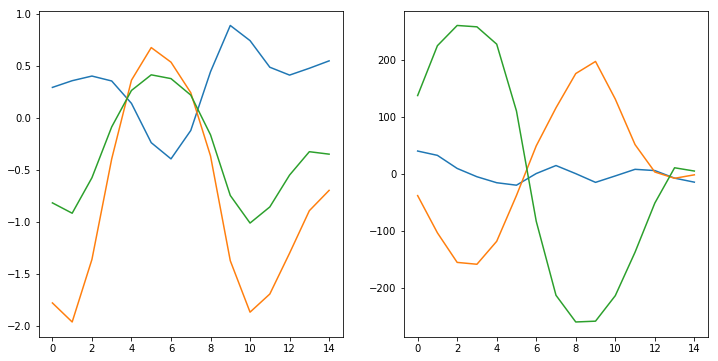

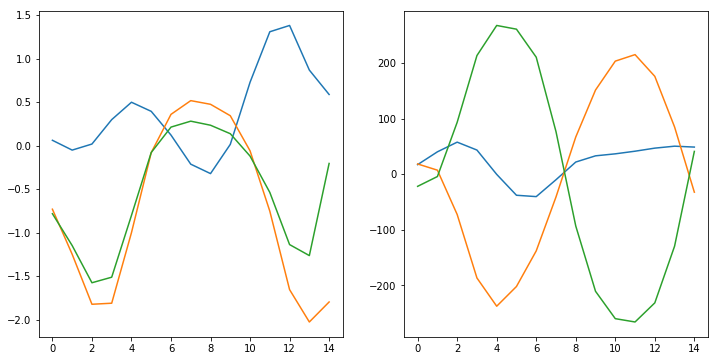

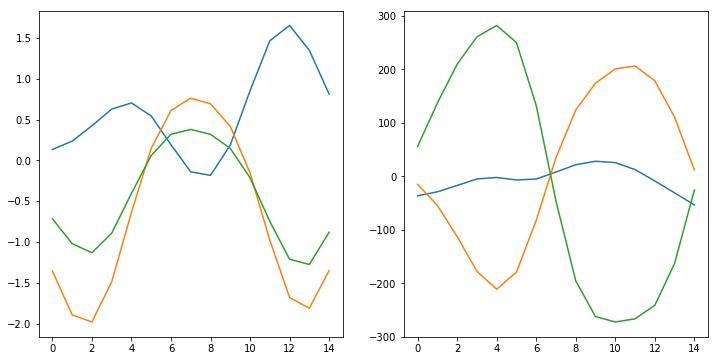

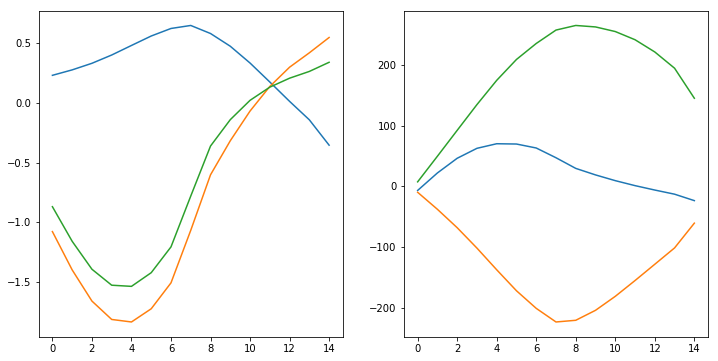

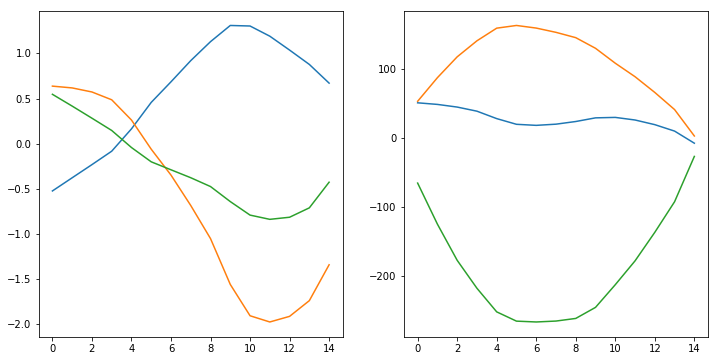

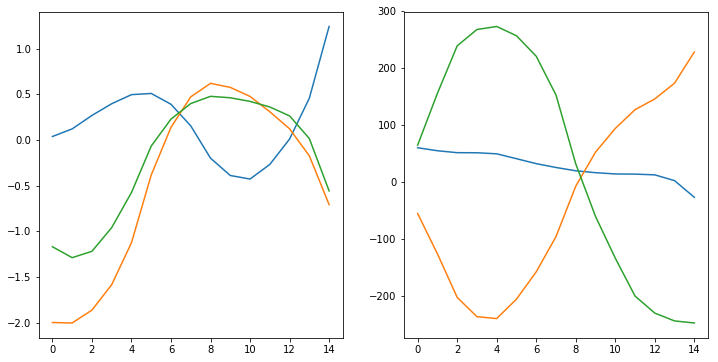

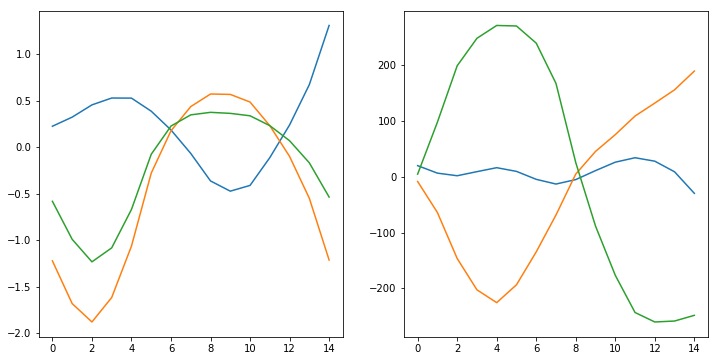

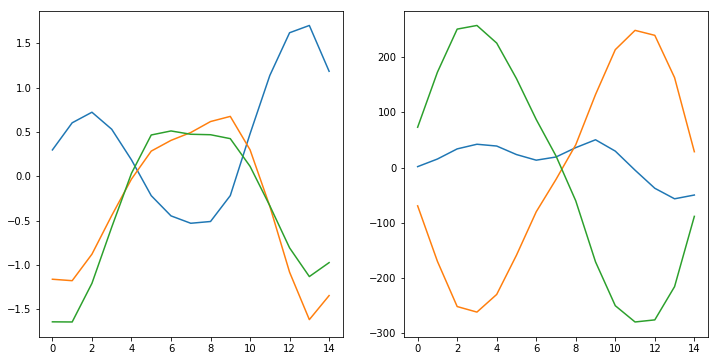

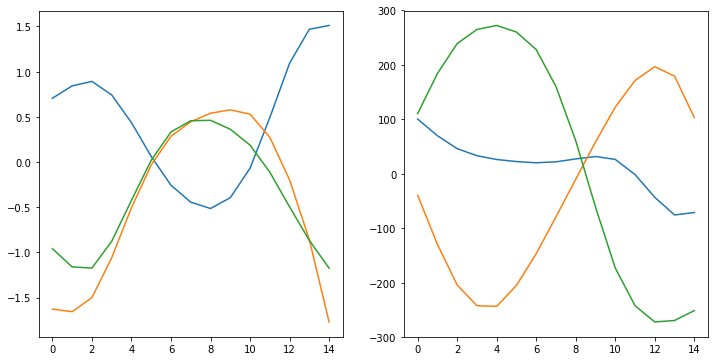

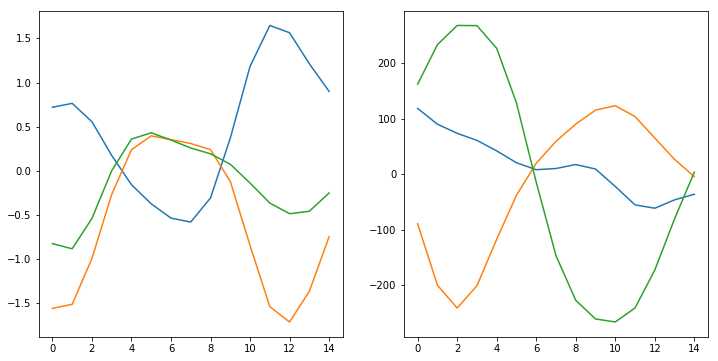

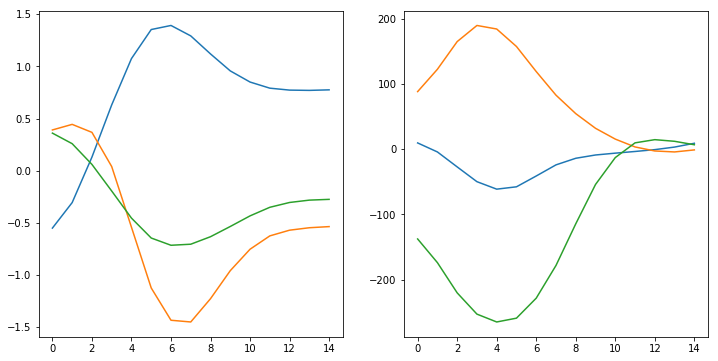

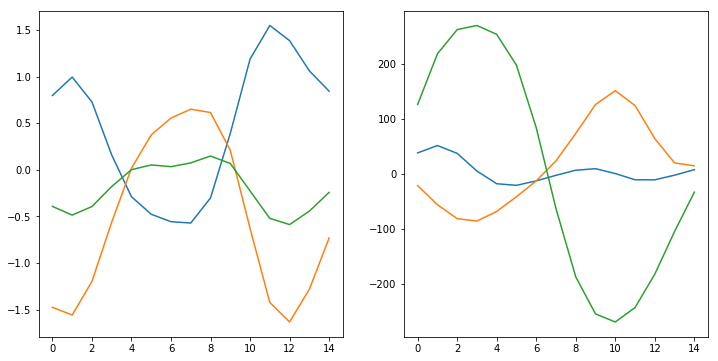

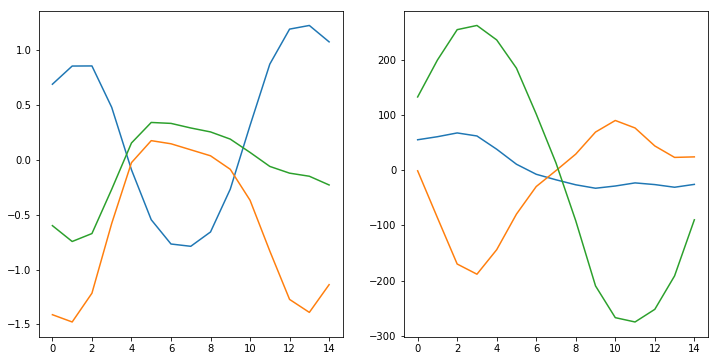

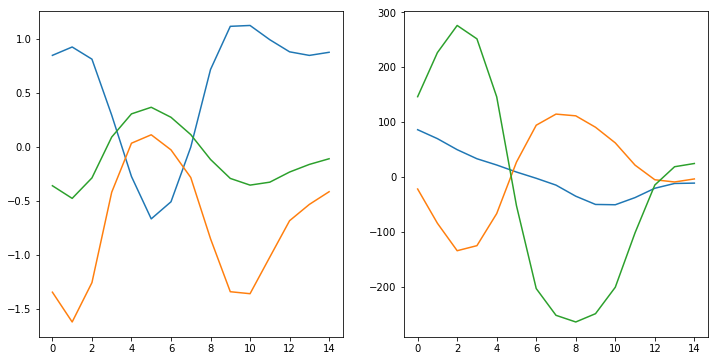

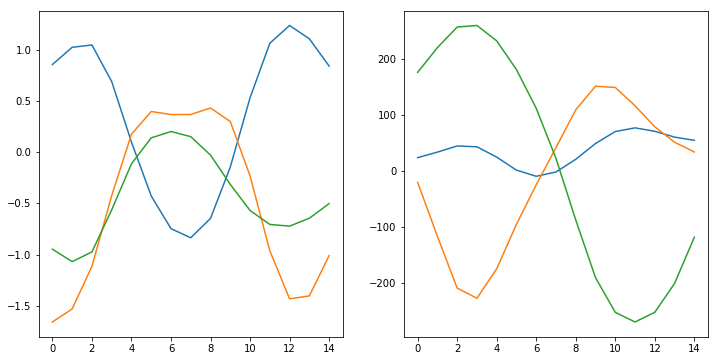

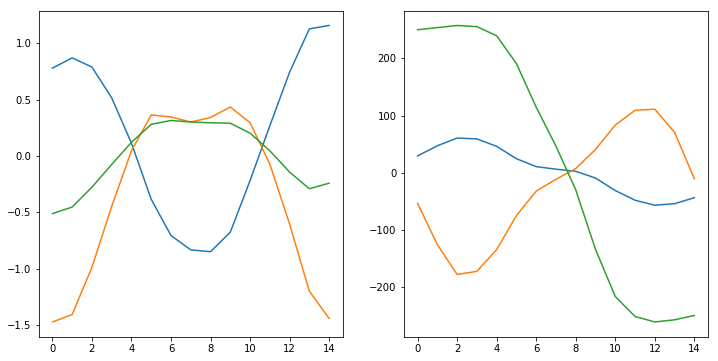

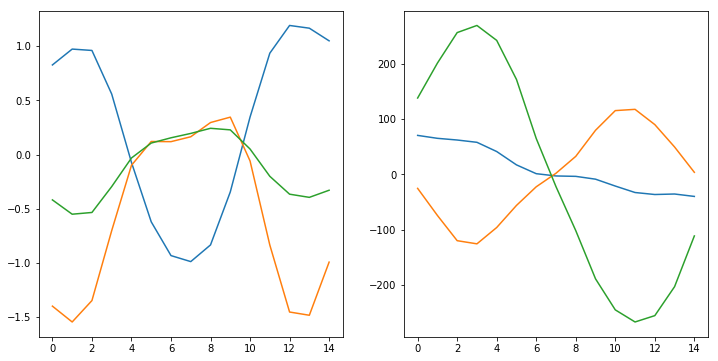

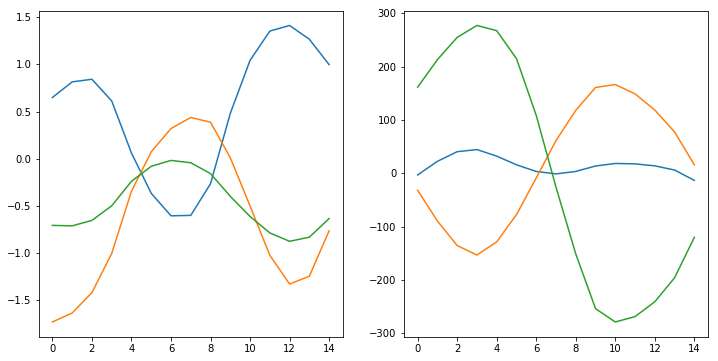

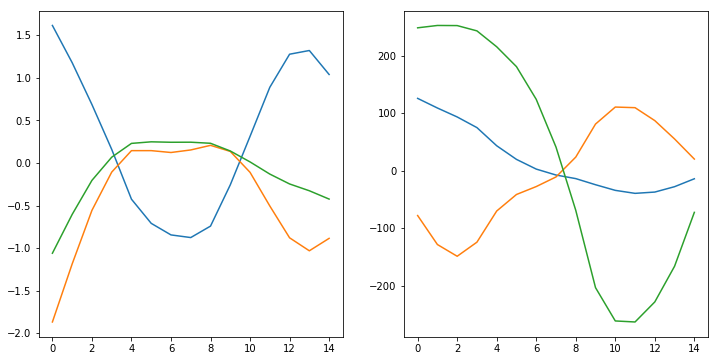

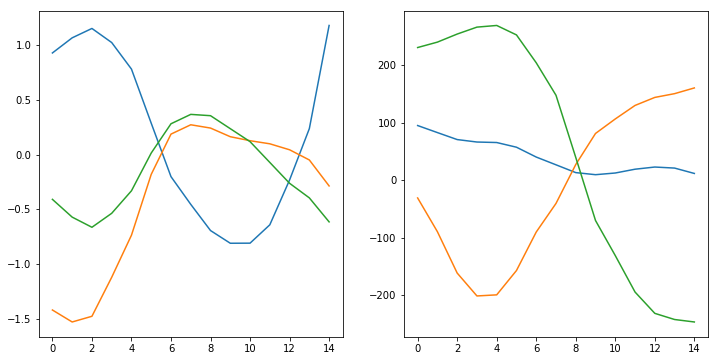

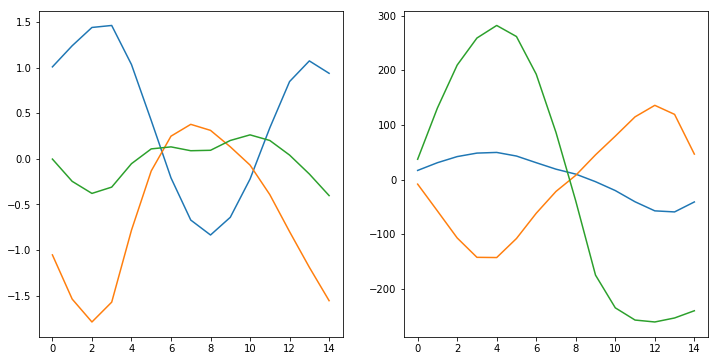

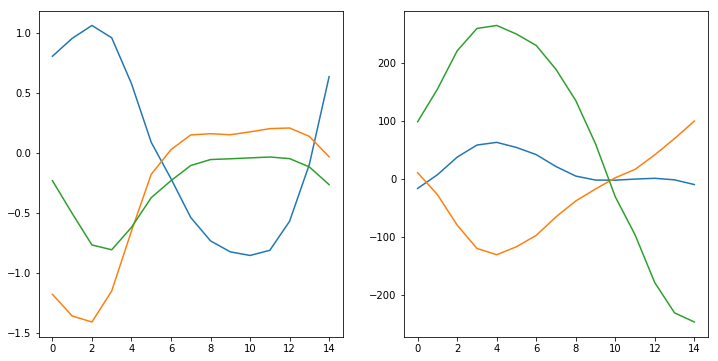

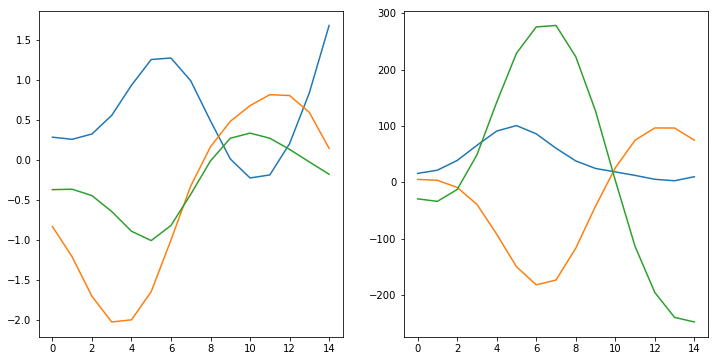

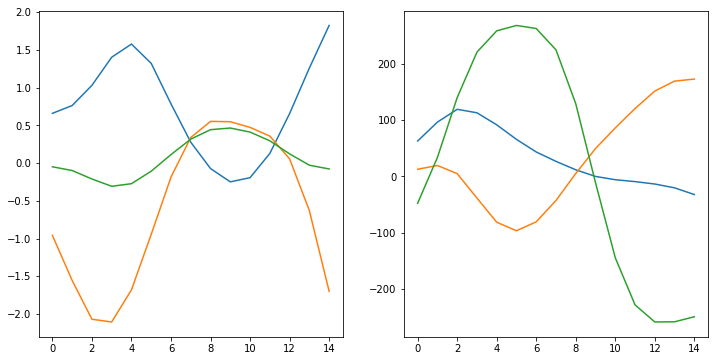

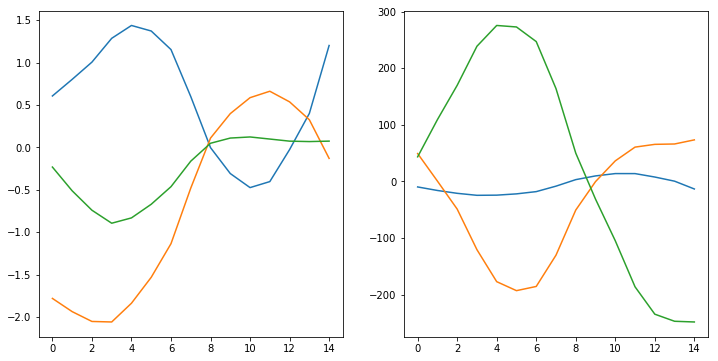

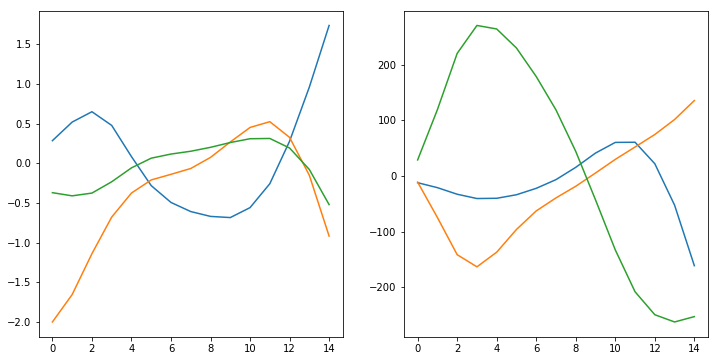

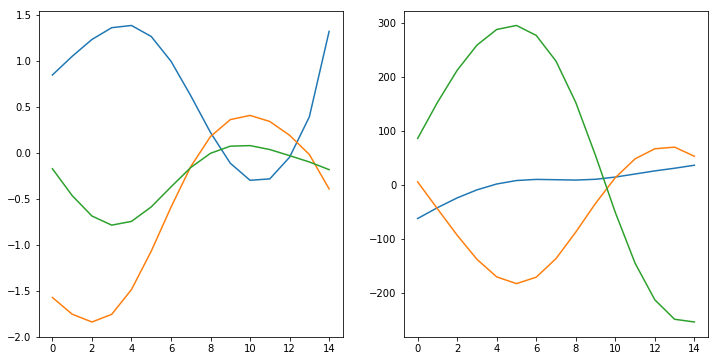

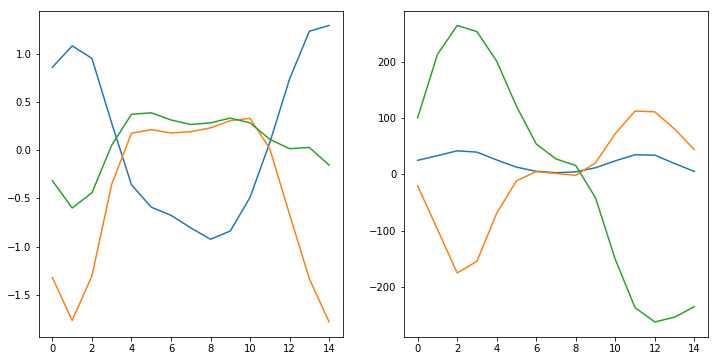

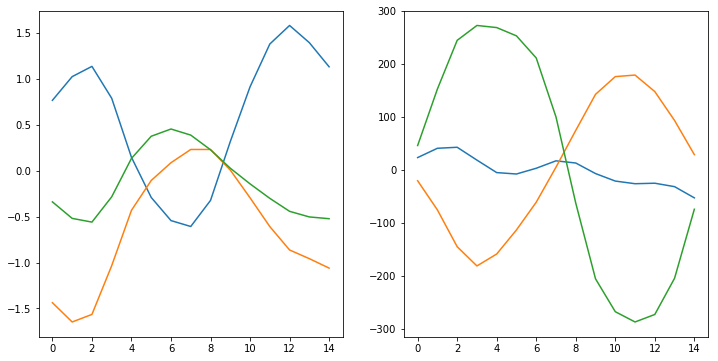

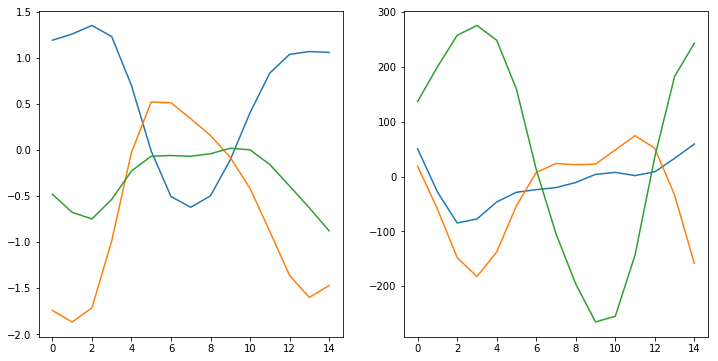

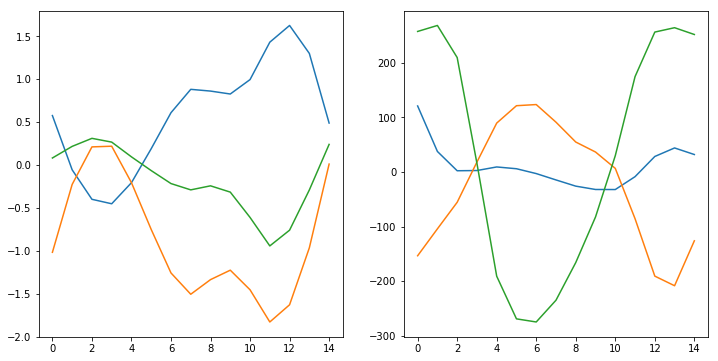

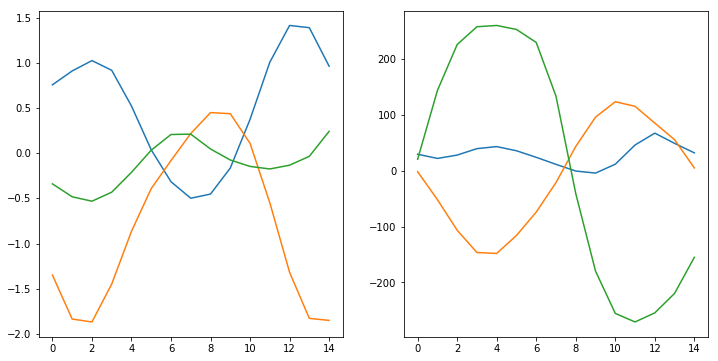

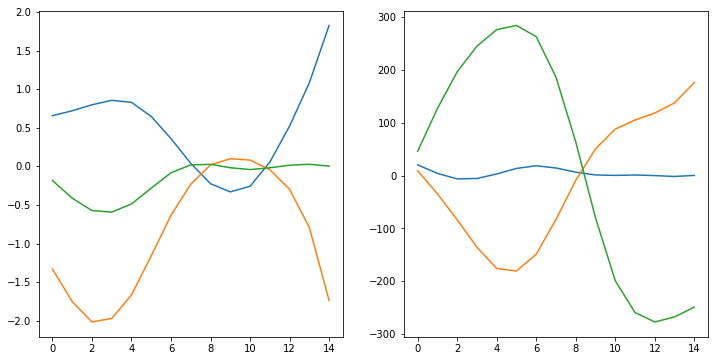

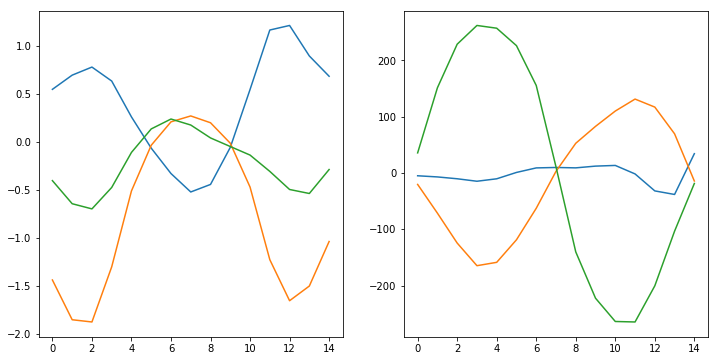

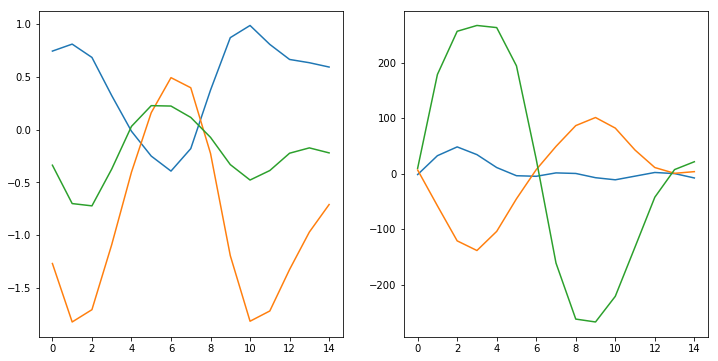

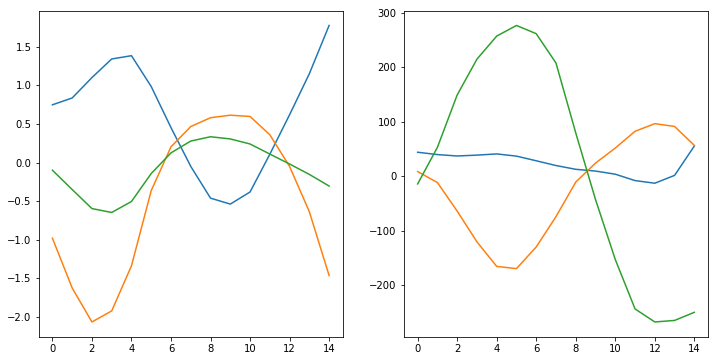

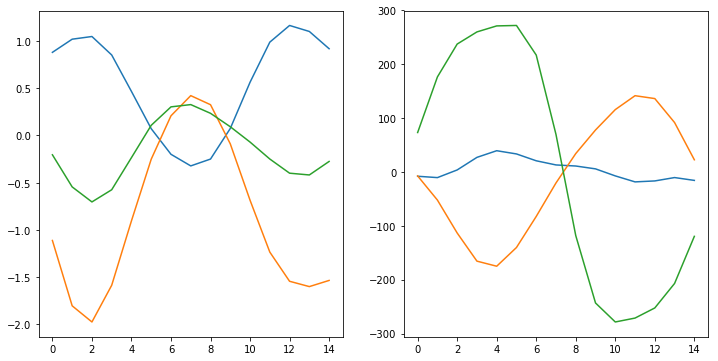

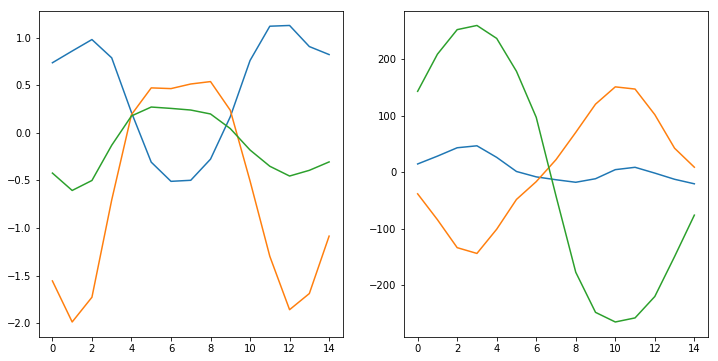

In [62]:
visualize_data_set(data)

## Creation big data for all classes

In [71]:
n_points = 15
classes = [{"class_name":"accelerometercircle", "class_len":394, "bad_img":bad_img_circl},
           {"class_name":"horizontal", "class_len":97, "bad_img":bad_img_hor},
           {"class_name":"vertical", "class_len":103, "bad_img":bad_img_vert}]

file_name = "data_for_recognition/accelerometer/%s_%d.dat"
big_data = {}
for cl in classes:
    class_name = cl["class_name"]
    files = [file_name%(class_name, i) for i in range(cl["class_len"])
             if i not in cl["bad_img"] and number_of_lines(file_name % (class_name, i)) > n_points]
    
    data = create_data_set(files, n_points)
    big_data[class_name] = data
    
np.save("data_for_recognition/accelerometer/big_data.npy", big_data)